# Code with explicit math imlpementation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os
from tensor_decompositions import compute_error

In [2]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}
Lx, Ly = 12.5, 15.6
print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
print(tensor_.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]

# Create log-transformed tensor
epsilon = 1e-10
tensor_combustion_log = np.zeros_like(tensor_combustion)
for i in range(tensor_combustion.shape[2]):
    tensor_combustion_log[:, :, i, :] = np.log(np.maximum(tensor_combustion[:, :, i, :], epsilon))
print(f"Log tensor created with shape: {tensor_combustion_log.shape}")

Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:24<00:00,  8.20it/s]


(400, 320, 8, 200)
Data loading complete!
Log tensor created with shape: (400, 320, 8, 200)


In [3]:
def select_rank_by_ratio(array, varepsilon):
    sorted_array = np.sort(array)[::-1]
    total_energy = np.sum(sorted_array)
    cumulative_energy = np.cumsum(sorted_array)
    num_components = np.sum(cumulative_energy <= varepsilon * total_energy) + 1
    return min(num_components, len(array))

In [4]:
# Sequentially truncated HOSVD on log tensor
start_t = time.time()
factors_st = []
current_tensor = tensor_combustion_log.copy()

for mode in range(current_tensor.ndim):
    unfolded = tl.unfold(current_tensor, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor = tl.tenalg.mode_dot(current_tensor, U_trunc.T, mode)
    factors_st.append(U_trunc)
core_st = current_tensor
end_t = time.time()
st_time = end_t - start_t
print(f"stHOSVD computed in {st_time:.2f} seconds")

# Reconstruct in log space
reconstruction_st_log = tl.tenalg.multi_mode_dot(core_st, factors_st, [0,1,2,3])

# Transform back to original space
reconstruction_st = np.exp(reconstruction_st_log) - epsilon

print(np.allclose(reconstruction_st, tensor_combustion))
error_st = compute_error(tensor_combustion, reconstruction_st)
print(f"stHOSVD relative error: {error_st:.6f}")

84
65
7
161
stHOSVD computed in 4.06 seconds
False
stHOSVD relative error: 0.043538


In [5]:
# Subsampled HOSVD (Gram matrix) on log tensor
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    print(unfolded.shape)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

(400, 64000)
74
(320, 80000)
65
(8, 3200000)
7
(200, 128000)
160
sub HOSVD computed in 2.78 seconds
Subsampled HOSVD computed in 2.78 seconds
False
Subsampled HOSVD relative error: 0.051311


In [6]:
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion_log.ndim):
    unfolded = tl.unfold(tensor_combustion_log[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion_log.ndim))], mode)
    U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
    trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = U[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion_log, [f.T for f in factors_sub], modes=list(range(tensor_combustion_log.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")

reconstruction_sub_log = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])

reconstruction_sub = np.exp(reconstruction_sub_log) - epsilon

print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")

74
65
7
160
sub HOSVD computed in 58.92 seconds
Subsampled HOSVD computed in 58.92 seconds
False
Subsampled HOSVD relative error: 0.051311


# Generated Code

In [7]:
# Comparison of subsampled HOSVD with different subsampling rates
subsampling_rates = [1, 2, 3, 5, 10]
results_gram = {'rates': [], 'times': [], 'errors': []}
results_svd = {'rates': [], 'times': [], 'errors': []}

for rate in subsampling_rates:
    print(f"\n{'='*60}")
    print(f"Processing subsampling rate: {rate}")
    print(f"{'='*60}")
    
    # ============ Gram Matrix Formulation ============
    print(f"\n--- Gram Matrix Formulation (rate={rate}) ---")
    start_t = time.time()
    factors_gram = []
    
    for mode in range(tensor_combustion_log.ndim):
        # Create subsampling slicing
        unfolded = tl.unfold(
            tensor_combustion_log[tuple(
                slice(None) if d == mode else slice(None, None, rate) 
                for d in range(tensor_combustion_log.ndim)
            )], 
            mode
        )
        
        # Compute Gram matrix
        g_matrix = unfolded @ unfolded.T
        eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
        eigenvalues = np.sqrt(np.abs(eigenvalues))
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Truncate
        trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.99)
        U_trunc = eigenvectors[:, :trunc_idx].real
        factors_gram.append(U_trunc)
    
    # Compute core
    core_gram = tl.tenalg.multi_mode_dot(
        tensor_combustion_log, 
        [f.T for f in factors_gram], 
        modes=list(range(tensor_combustion_log.ndim))
    )
    
    end_t = time.time()
    gram_time = end_t - start_t
    
    # Reconstruct
    reconstruction_gram_log = tl.tenalg.multi_mode_dot(core_gram, factors_gram, [0,1,2,3])
    reconstruction_gram = np.exp(reconstruction_gram_log) - epsilon
    error_gram = compute_error(tensor_combustion, reconstruction_gram)
    
    results_gram['rates'].append(rate)
    results_gram['times'].append(gram_time)
    results_gram['errors'].append(error_gram)
    
    print(f"Time: {gram_time:.3f} seconds")
    print(f"Reconstruction error: {error_gram:.6f}")
    
    # ============ SVD Formulation ============
    print(f"\n--- SVD Formulation (rate={rate}) ---")
    start_t = time.time()
    factors_svd = []
    
    for mode in range(tensor_combustion_log.ndim):
        # Create subsampling slicing
        unfolded = tl.unfold(
            tensor_combustion_log[tuple(
                slice(None) if d == mode else slice(None, None, rate) 
                for d in range(tensor_combustion_log.ndim)
            )], 
            mode
        )
        
        # Compute SVD
        U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
        
        # Truncate
        trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
        U_trunc = U[:, :trunc_idx].real
        factors_svd.append(U_trunc)
    
    # Compute core
    core_svd = tl.tenalg.multi_mode_dot(
        tensor_combustion_log, 
        [f.T for f in factors_svd], 
        modes=list(range(tensor_combustion_log.ndim))
    )
    
    end_t = time.time()
    svd_time = end_t - start_t
    
    # Reconstruct
    reconstruction_svd_log = tl.tenalg.multi_mode_dot(core_svd, factors_svd, [0,1,2,3])
    reconstruction_svd = np.exp(reconstruction_svd_log) - epsilon
    error_svd = compute_error(tensor_combustion, reconstruction_svd)
    
    results_svd['rates'].append(rate)
    results_svd['times'].append(svd_time)
    results_svd['errors'].append(error_svd)
    
    print(f"Time: {svd_time:.3f} seconds")
    print(f"Reconstruction error: {error_svd:.6f}")

print(f"\n{'='*60}")
print("All computations completed!")
print(f"{'='*60}")


Processing subsampling rate: 1

--- Gram Matrix Formulation (rate=1) ---
Time: 2.917 seconds
Reconstruction error: 0.041639

--- SVD Formulation (rate=1) ---
Time: 101.668 seconds
Reconstruction error: 0.041639

Processing subsampling rate: 2

--- Gram Matrix Formulation (rate=2) ---
Time: 0.991 seconds
Reconstruction error: 0.051311

--- SVD Formulation (rate=2) ---
Time: 11.822 seconds
Reconstruction error: 0.051311

Processing subsampling rate: 3

--- Gram Matrix Formulation (rate=3) ---
Time: 0.586 seconds
Reconstruction error: 0.060234

--- SVD Formulation (rate=3) ---
Time: 2.872 seconds
Reconstruction error: 0.060234

Processing subsampling rate: 5

--- Gram Matrix Formulation (rate=5) ---
Time: 0.518 seconds
Reconstruction error: 0.079465

--- SVD Formulation (rate=5) ---
Time: 1.086 seconds
Reconstruction error: 0.079465

Processing subsampling rate: 10

--- Gram Matrix Formulation (rate=10) ---
Time: 0.363 seconds
Reconstruction error: 0.168477

--- SVD Formulation (rate=10)

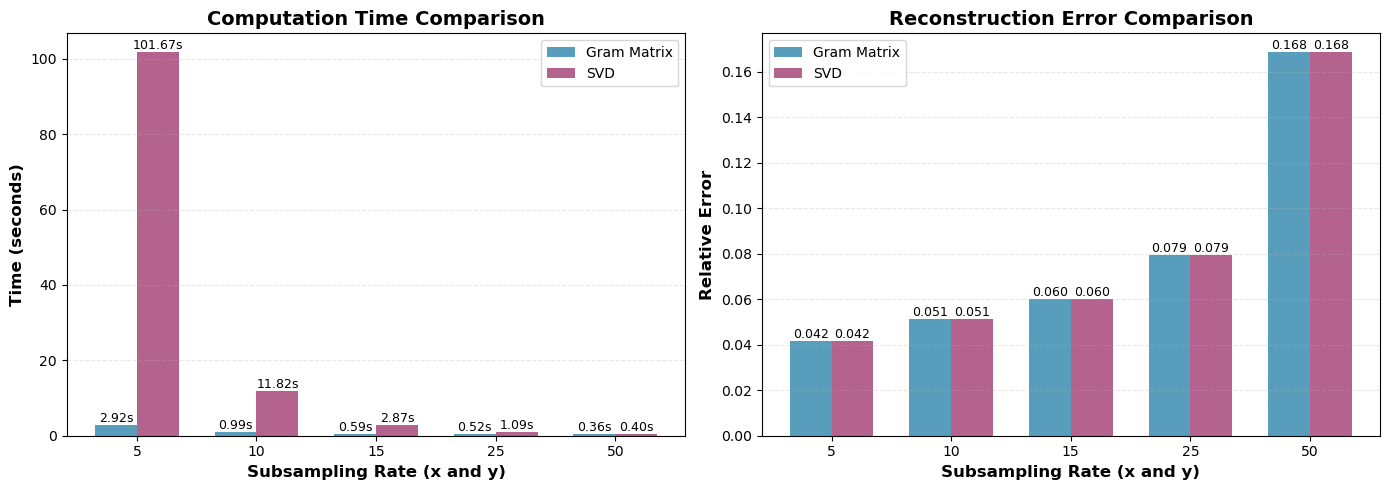


SUMMARY TABLE
Rate       Gram Time (s)   SVD Time (s)    Gram Error      SVD Error      
--------------------------------------------------------------------------------
1          2.917           101.668         0.041639        0.041639       
2          0.991           11.822          0.051311        0.051311       
3          0.586           2.872           0.060234        0.060234       
5          0.518           1.086           0.079465        0.079465       
10         0.363           0.403           0.168477        0.168477       


In [15]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Computation Times
ax1 = axes[0]
x = np.arange(len(subsampling_rates))
width = 0.35

bars1 = ax1.bar(x - width/2, results_gram['times'], width, 
                label='Gram Matrix', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x + width/2, results_svd['times'], width, 
                label='SVD', color='#A23B72', alpha=0.8)

ax1.set_xlabel('Subsampling Rate (x and y)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([rate * 5 for rate in subsampling_rates])
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Reconstruction Errors
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, results_gram['errors'], width, 
                label='Gram Matrix', color='#2E86AB', alpha=0.8)
bars4 = ax2.bar(x + width/2, results_svd['errors'], width, 
                label='SVD', color='#A23B72', alpha=0.8)

ax2.set_xlabel('Subsampling Rate (x and y)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Relative Error', fontsize=12, fontweight='bold')
ax2.set_title('Reconstruction Error Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([rate * 5 for rate in subsampling_rates])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Rate':<10} {'Gram Time (s)':<15} {'SVD Time (s)':<15} {'Gram Error':<15} {'SVD Error':<15}")
print("-"*80)
for i in range(len(subsampling_rates)):
    print(f"{results_gram['rates'][i]:<10} {results_gram['times'][i]:<15.3f} "
          f"{results_svd['times'][i]:<15.3f} {results_gram['errors'][i]:<15.6f} "
          f"{results_svd['errors'][i]:<15.6f}")
print("="*80)